In [1]:
import numpy as np

from scipy import linalg
from scipy.special import erf as sperf

import matplotlib.pyplot as plt

In [2]:
def infer_LAD(x, y, regu=0.1,tol=1e-8, max_iter=5000):
## 2019.12.26: Jungmin's code    
    weights_limit = sperf(1e-10)*1e10
    
    s_sample, s_pred = x.shape
    s_sample, s_target = y.shape
    
    mu = np.zeros(x.shape[1])

    w_sol = 0.0*(np.random.rand(s_pred,s_target) - 0.5)
    b_sol = np.random.rand(1,s_target) - 0.5

#     print(weights.shape)
    for index in range(s_target):
        error, old_error = np.inf, 0
        weights = np.ones((s_sample, 1))
        cov = np.cov(np.hstack((x,y[:,index][:,None])), rowvar=False, \
                     ddof=0, aweights=weights.reshape(s_sample))
        cov_xx, cov_xy = cov[:s_pred,:s_pred],cov[:s_pred,s_pred:(s_pred+1)]

#         print(cov.shape, cov_xx.shape, cov_xy.shape)
        counter = 0
        while np.abs(error-old_error) > tol and counter < max_iter:
            counter += 1
            old_error = np.mean(np.abs(b_sol[0,index] + x.dot(w_sol[:,index]) - y[:,index]))
#             old_error = np.mean(np.abs(b_sol[0,index] + x_test.dot(w_sol[:,index]) - y_test[:,index]))
#             print(w_sol[:,index].shape, npl.solve(cov_xx, cov_xy).reshape(s_pred).shape)

            # 2019.12.26: Tai - added regularization
            sigma_w = np.std(w_sol[:,index])
                
            w_eq_0 = np.abs(w_sol[:,index]) < 1e-10
            mu[w_eq_0] = 2./np.sqrt(np.pi)
        
            mu[~w_eq_0] = sigma_w*sperf(w_sol[:,index][~w_eq_0]/sigma_w)/w_sol[:,index][~w_eq_0]
                                                        
            w_sol[:,index] = np.linalg.solve(cov_xx + regu*np.diag(mu),cov_xy).reshape(s_pred)
        
            b_sol[0,index] = np.mean(y[:,index]-x.dot(w_sol[:,index]))
            weights = (b_sol[0,index] + x.dot(w_sol[:,index]) - y[:,index])
            sigma = np.std(weights)
            error = np.mean(np.abs(weights))
#             error = np.mean(np.abs(b_sol[0,index] + x_test.dot(w_sol[:,index]) - y_test[:,index]))
            weights_eq_0 = np.abs(weights) < 1e-10
            weights[weights_eq_0] = weights_limit
            weights[~weights_eq_0] = sigma*sperf(weights[~weights_eq_0]/sigma)/weights[~weights_eq_0]
            
            #weights = sigma*sperf(weights/sigma)/weights            
            cov = np.cov(np.hstack((x,y[:,index][:,None])), rowvar=False, \
                         ddof=0, aweights=weights.reshape(s_sample))
            cov_xx, cov_xy = cov[:s_pred,:s_pred],cov[:s_pred,s_pred:(s_pred+1)]
#             print(old_error,error)
    #return b_sol,w_sol 
    return b_sol[0][0],w_sol[:,0] # only one target

In [3]:
n_seq = 200
n_var = 10

# generage x,w,h0
x = np.random.rand(n_seq,n_var)-0.5
print(x.shape)

w = np.random.rand(n_var) - 0.5
print(w.shape)

h0 = np.random.rand() - 0.5
print('h0:',h0)

# h = h0 + w*x
h = h0 + x.dot(w)

(200, 10)
(10,)
h0: -0.390123016248456


In [4]:
h0_pred,w_pred = infer_LAD(x, h[:,np.newaxis],regu=0.0)

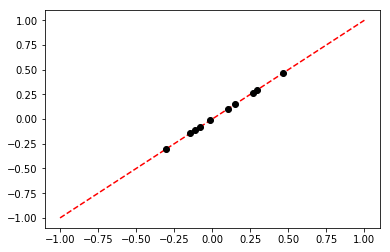

In [5]:
plt.plot([-1,1],[-1,1],'r--')
plt.plot(w,w_pred,'ko')

In [6]:
print('h0_pred:',h0_pred)

h0_pred: -0.39012301624845597
